---

# PRÁCTICA 1 ANÁLISIS DE DATOS

---


In [22]:
# Importamos los módulos necesarios para el desarollo del trabajo
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4 as nc
import seaborn as sns
from scipy import stats as stats
import datetime as dt
import math
from matplotlib import style
plt.style.use('seaborn')

## 1.3 : Análisis con datos del reanálisis NCEP/NCAR 

Lee los datos para cada meses por separado y selecciona el punto de la malla que esté más próximo a Barajas (40.494oN, 3.567oW).


### 1.3.1 Caracterización del ciclo estacional. 

Caracteriza el ciclo estacional de la temperatura media diaria en superficie en Barajas empleando boxplots: En un mismo gráfico dibuja 12 diagramas de cajas y bigotes para caracterizar los datos de cada mes por separado. Puedes incluir la media de cada mes con una línea. Comenta los resultados.


In [23]:
# Path del directorio donde se guardan los datos 
path='/Users/cova/Desktop/MASTER METEO/ANALISIS DE DATOS/Practica 1/Datos/NCEP-NCAR/'

# Lista con el nombre de los archivos que guardan la información de cada mes
meses_NCEP=['NCEP_NCAR_air_PI_mes_{}.nc'.format(i) for i in range(1,13)] # Lista con todos los nombres de los archivos


In [24]:
# Se fija la latitud y longitud del aeropuerto de Barajas
lon_barajas = -3.567
lat_barajas = 40.494

In [25]:
df_arr = np.empty((1,4)) # Array vacio para empezar a introducirle los datos (1 fila vacia, 4 columnas)

for file in meses_NCEP: # Bucle a lo largo de todos los nombres de archivo
    fil = nc.Dataset(path + file,'r') # Leemos con netCDF4
    lon = fil.variables['lon'][:] # Asignamos las variables
    lat = fil.variables['lat'][:]
    tiempo = fil.variables['time'] # Se escribe sin los dos puntos para que sea variable ncdf, con ellos es un masked array
    tmedia = fil.variables['air'][:]
    tmedia=tmedia-273.15 # Pasar las temperaturas a Kelvin
    
    # Calculamos los índices de latitud y longitud más cercanos a las de barajas con argmin
    lon_i = np.abs(lon-lon_barajas).argmin()
    lat_i = np.abs(lat-lat_barajas).argmin()

    temp = tmedia[:,lat_i,lon_i] # Seleccionamos esos valores de lat y lon para las temperaturas
    tiempodates = nc.num2date(tiempo[:],tiempo.units) # Cambiamos el tiempo a un array con el formato de las fechas Dia-Mes-Año

    fechas = np.array([[fecha.day, fecha.month, fecha.year] for fecha in tiempodates]) # Separamos las fechas en un array de dias, meses y años

    df_arr_i = np.c_[fechas,temp]   # Concatenamos en el segundo eje las temperaturas y las fechas
    df_arr = np.r_[df_arr,df_arr_i] # Añadimos al array conjunto con todos los meses


# Transformamos la lista conjunta a un dataframe dando los nombres de las columnas y los tipos de variables
df = pd.DataFrame(df_arr[1:,:],columns=['day','month','year','temp']).astype({'day':int, 'month':int,'year':int}).dropna()

# Imprimimos el DataFrame
df

,day,month,year,temp
0,1,1,1990,1.730011
1,2,1,1990,0.000000
2,3,1,1990,2.930023
3,4,1,1990,0.079987
4,5,1,1990,-1.519989
...,...,...,...,...
10952,27,12,2019,0.925018
10953,28,12,2019,-0.074982
10954,29,12,2019,-1.524994
10955,30,12,2019,-2.100006


In [26]:
# En el DataFrame se eliminan los datos que difieren demnasiado de los valores, por posibles errores en el reanalisis y se cambian por NaN
display(df[-50 > df['temp']])   
df[-50 > df['temp']]  = np.NaN  # Lo cambio por NaN
df[100 < df['temp']]  = np.NaN

,day,month,year,temp


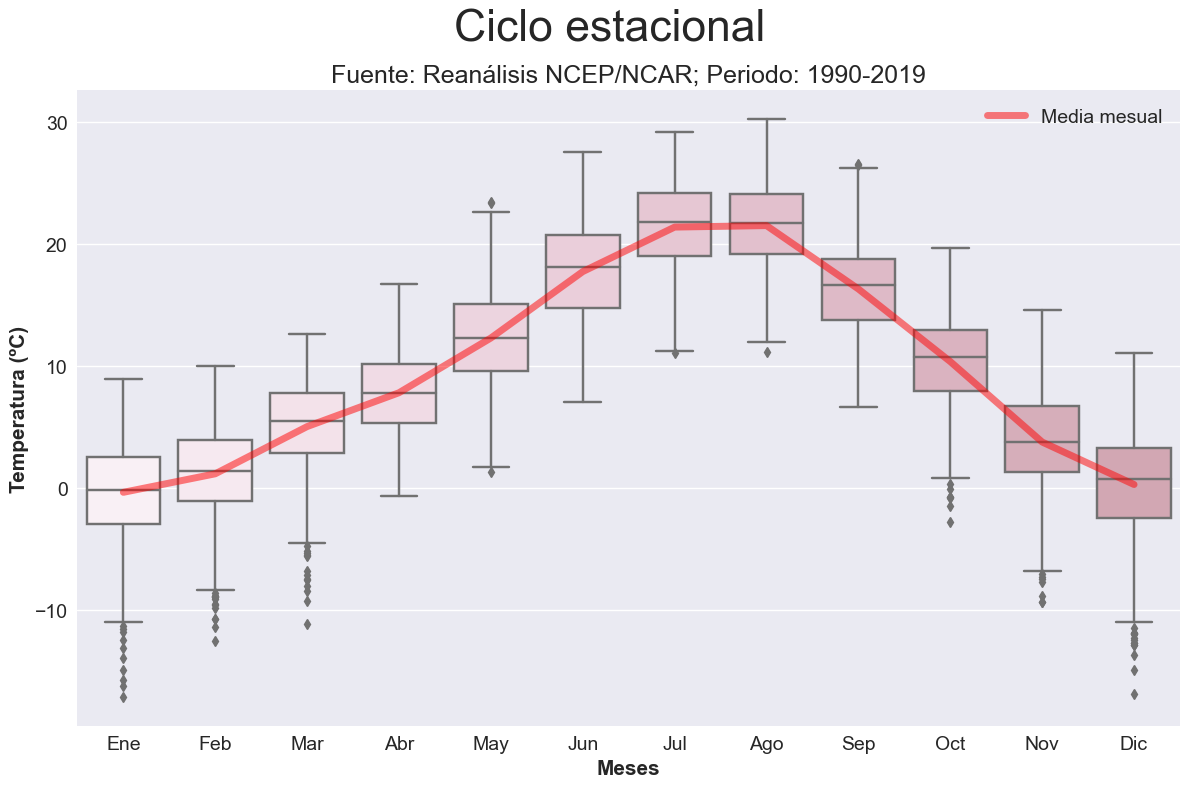

In [27]:
cus = sns.color_palette("ch:start=1.2,rot=-0.2,dark=0.7, light=.95",12) # Paleta de color elegida
def climograma(df,start_year,end_year,save=False,violin = False, outliers = True, figname='barajas',fuente='',palette=cus):
    ''' 
    Función para realizar boxplots del ciclo estacional a partir de unos datos de temperatura a 2m.

    Entradas:
    - df: DataFrame con los datos de temperatura, extructurado por columnas de 'day','month','year','temp'
    - start_year: año de inicio del periodo que queremos representar 
    - end_year: año de fin del periodo que queremos representar 
    - save: si se quiere guardar la figura poner save=1
    - violin: si se quiere represnetar un diagrama de violines poner violin=1
    - outliers: si se quieren quitar los outliers del boxplot poner outliers=0
    - figname: nombre para el png si se pide guardar 'figname'+'.png'
    - fuente: str con el nombre de la fuente de los datos 
    - palette: paleta de colores que se quiere usar

    Salidas:
    - Tupla con la figura (fig) y el axis (ax) donde se representa el plot.
    
    '''
    df = df[(start_year <= df['year'])&(df['year'] <= end_year)]    # Selecciono los años
    means = df.groupby(['month'],dropna=True).mean('temp')          # Media de cada mes para representar encima    
    fig, ax = plt.subplots(figsize=(12,8))
    meses = ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic'] # Nombres de los meses para los xtick
    if violin == True: # Si queremos representarlo como violines
        sns.violinplot(data=df, x='month', y='temp', ax=ax, showfliers = False)
    else: 
        if outliers == True: # Boxplot con outliers 
            sns.boxplot(data=df, x='month', y='temp', ax=ax,zorder=2,palette=palette) #,whis=2)
            
        else: # Boxplot sin outliers 
            sns.boxplot(data=df, x='month', y='temp', ax=ax, showfliers = False,boxprops=dict(alpha=0.7,zorder= 2),zorder=2)


    # Plot de la línea de medias
    ax.plot(np.arange(12), means['temp'],linewidth=5, color ='r',zorder=3, alpha=0.5, label='Media mesual')
    # Ajustes del ax
    ax.set_ylabel('Temperatura (ºC)', size=15 , fontweight = 'bold')
    ax.set_xlabel('Meses', size=15, fontweight = 'bold')
    ax.set_xticks(np.arange(12),meses,size=14) # Para cambiar las etiquetas a los nombres de meses
    ax.yaxis.set_tick_params(labelsize=14)
    ax.legend(prop={'size':14})

    mid = (fig.subplotpars.right + fig.subplotpars.left)/2 # Para alinear el title y el suptitle
    plt.suptitle('Ciclo estacional',size=32, x=mid)
    plt.title(u'Fuente: %s; Periodo: %i-%i'%(fuente,start_year,end_year), size=18)
    plt.tight_layout()
    if save == True:  # Si queremos guardar la figura
        fig.savefig(figname+'.png',dpi=500,facecolor='w')
        
    return fig, ax

fig, ax = climograma(df,1990,2019,fuente=u'Reanálisis NCEP/NCAR')

---

### Apartado 1.3.2 Caracterización de la distribución para enero y julio.

Repetir el cálculo del apartado 1.1.2 con los datos del CPC. Comentar los resultados y las diferencias/semejanzas con lo obtenido en anteriores apartados

In [28]:
# Los datos de esta base están dados como temperaturas medias diarias, por lo que se tomarán los meses de enero y julio.
media_diaria_enero= df[df['month']==1]
media_diaria_julio= df[df['month']==7]

In [29]:
def histogram_plotter_with_normal_estimation(data:pd.DataFrame,variable:str,variable_name:str,title:str, verbose:bool=True) -> None:
    """
    description:
    --------------------------------------
    
    arguments:
        - data: entry dataframe
        - variable: name of the variable of study
        - title: plot title
        - verbose: True if you want the stats asociated with the variable
    """
    mean= np.mean(data[variable])
    std= np.std(data[variable])
    n= np.shape(data[variable])[0]
    bins= np.arange(np.min(data[variable]),np.max(data[variable]),step=(np.max(data[variable])-np.min(data[variable]))/20)
    fig,ax= plt.subplots()
    sns.histplot(data, x=variable,bins=bins,stat='density',color='pink')
    normal_distribution= stats.norm.pdf(bins,mean,std)
    plt.plot(bins,normal_distribution,'magenta',label='Theoric')
    plt.legend(loc='best')
    plt.xlabel(variable_name)
    plt.title(title)
    plt.show()
    quantile_data= np.quantile(data[variable],(0.05,0.95))
    quantile_theoric= [stats.norm.ppf(0.05,mean,std),stats.norm.ppf(0.95,mean,std)]
    if verbose:
        print('Percentiles for the data are: q(5%%)=%.2f and q(95%%)= %.2f' %(quantile_data[0],quantile_data[1]))
        print('Percentiles for the theoric distribution are: q(5%%)=%.2f and q(95%%)= %.2f' %(quantile_theoric[0],quantile_theoric[1]))
        print('Índice de Confianza del 95%')
        alfa=0.05
        #We must use the t-student distribution, beacuse with don't now the standard deviation of the data
        t_alpha_2= stats.t.ppf(1-alfa/2,n-1)
        ic= t_alpha_2*std/np.sqrt(n)
        print('IC= [%.2f+-%.2f] (ºC)'%(mean,ic))
        print('With scipy function:')
        ic_scipy=stats.t.interval(alpha=0.95,df=n-1,loc=mean,scale= std/np.sqrt(n))
        print(ic_scipy)



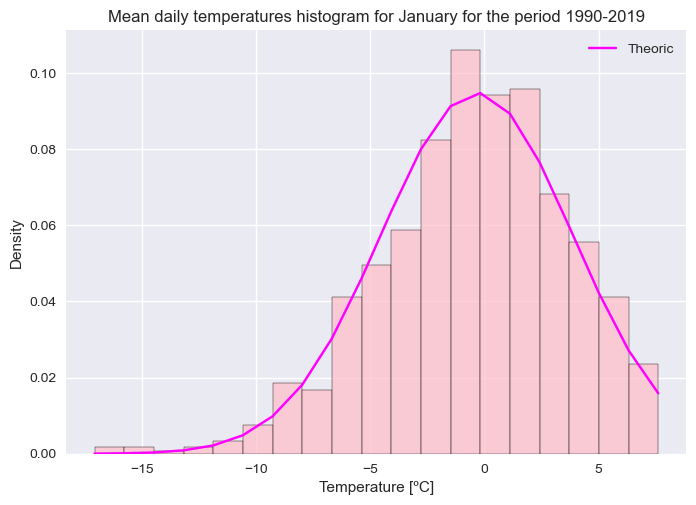

Percentiles for the data are: q(5%)=-7.64 and q(95%)= 6.23
Percentiles for the theoric distribution are: q(5%)=-7.26 and q(95%)= 6.59
Índice de Confianza del 95%
IC= [-0.34+-0.27] (ºC)
With scipy function:
(-0.6059780253902167, -0.06438966876720931)


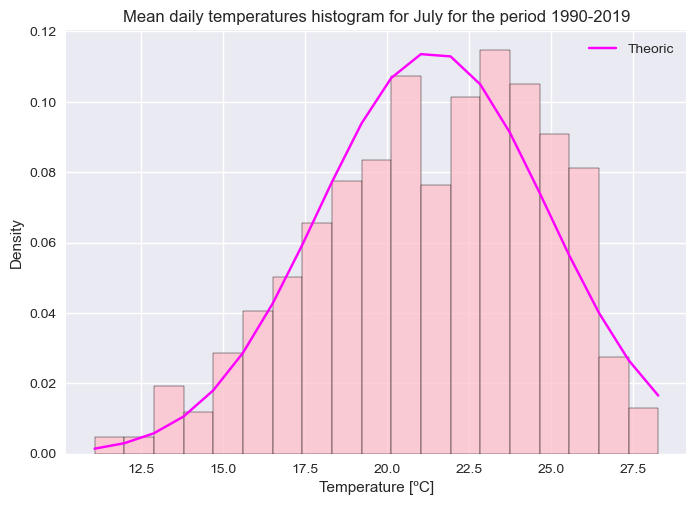

Percentiles for the data are: q(5%)=15.27 and q(95%)= 26.33
Percentiles for the theoric distribution are: q(5%)=15.66 and q(95%)= 27.15
Índice de Confianza del 95%
IC= [21.41+-0.22] (ºC)
With scipy function:
(21.181912648267012, 21.63150261655994)


In [30]:
# Llamamos a la función para representar el histograma y calcular los valores que piden para cada mes
histogram_plotter_with_normal_estimation(media_diaria_enero,'temp','Temperature [ºC]','Mean daily temperatures histogram for January for the period 1990-2019')
histogram_plotter_with_normal_estimation(media_diaria_julio,'temp','Temperature [ºC]','Mean daily temperatures histogram for July for the period 1990-2019')

---

### Apartado 1.3.3 Cambio climático. Contraste de hipótesis

Calcula la media de la temperatura en enero y julio para el periodo 1973- 1989. Calcula la desviación típica de la temperatura en enero y julio para el periodo 1973-1989 y el periodo 1990-2019. Haz los contrastes de hipótesis pertinentes para decir si ha cambiado significativamente la temperatura en Barcelona en ambos periodos.


In [31]:
# Voy a hacer una clase para los tests estadísticos

class StadisticalTests():
    # El método __init__ incluye toda la lógica necesaria para los índices de entrada y etiqueta.
    def __init__(self, x, y, alpha) -> None:
        
        self.x     = x
        self.y     = y
        self.alpha = alpha
   
    def f_test_stats(self) -> float:
        """
            Metodo que calcula el resultado p del test de Fisher para las varianzas, utilizando funciones de scipy.stats.

        Returns:
            float: el valor p. Si nuestro alpha que solemos determinarlo en 0.05, es mayor que p entonces nuestra hipotesis se acepta
                   en cambio, si el manor, debemos rechazar la hipotesis realizada.
        """
        
        # Cálculo del estadístico
        f = np.var (self.x, ddof = 1) /np.var (self.y, ddof = 1)
        
        # Calculo de la p si esta es menor que 0.05 la aceptamos
        p = 1- stats.f.cdf (f, self.x.size-1, self.y.size-1) 
        return p
    
    def _f_fisher(self):
   
        n1 = self.x.size
        n2 = self.y.size
        
        f = stats.f.interval(self.alpha, n1, n2, loc=0, scale=1)
        return f
    
    def f_test_manual(self) -> bool:
        """
            Otro método para calcular el test de Fisher pero esta vez implementado de manera manual.
        
        Returns:
            bool: si el estadístico calculado, f , está dentro de nuestro intervalo de significancia
                devolvemos True sino False.
        """
        # Cálculo del estadístico
        f = np.var (self.x, ddof = 1) /np.var (self.y, ddof = 1)
        f=1 # porque suponemos que son iguales
        
        # Intervalo de significancia con el alpha que hemos determinado
        isig = self._f_fisher()
        
        # Aceptamos o no la hipotesis?
        if f > isig[0] and f<isig[1]:
            print(f'Se ha aceptado la hipotesis de que las varianzas son iguales con una confianza de {self.alpha}.')
            return True
        else:
            print(f'Se ha rechazado la hipotesis de que las varianzas son iguales con una confianza de {self.alpha}.')
            return False
    
    def _z(self):
        
        z = abs(np.mean(self.x) - np.mean(self.y)) / np.sqrt(np.var(self.x,ddof=1) / self.x.size + np.var(self.y,ddof=1) / self.y.size)
        return z

    def mean_test(self) -> bool:
        # Calculo valor con el que voy a comparar mi muestra
        z_alpha_2 = stats.norm.ppf(1-self.alpha/2)
    
        z = self._z()
        
        if z <= z_alpha_2:
            # Se acepta la hipotesis
            print(f'Se ha aceptado la hipotesis de que las medias son iguales con una confianza de {self.alpha}.')
            # return True
        else:
            # Se anula la hipotesis
            print(f'Se ha rechazado la hipotesis de que las medias son iguales con una confianza de {self.alpha}.')
            # return False
        
    def mean_test_stats(self):

        return stats.ttest_ind(self.x, self.y, nan_policy='omit', equal_var=False)
    

In [32]:
def readDataFrame(stationName):
    url = '/Users/cova/Desktop/MASTER METEO/ANALISIS DE DATOS/Practica 1/isd-history.csv'
    c=pd.read_csv(url)

    #Seleccionamos los años de inicio y final de lectura
    yearInit = 1990
    yearEnd = 2020

    #Construimos el código que necesitamos para bajar los datos de la estación:
    station=str(c.loc[(c['STATION NAME']==stationName)]['USAF'].values[0]) + '-' + \
            str(c.loc[(c['STATION NAME']==stationName)]['WBAN'].values[0])
    print('Seleccionada la estacion ' + stationName + ' con código ' + station)

    #Definimos las columnas y el tipo de dato que va a tener el DataFrame donde vamos a alojar los datos de la estación
    colNames=['year','month','day','hour','temp','tempd','slp','windDir','windSpeed','cloud','pcp1h','pcp6h']
    dataType=['int','int','int','int','float','float','int','int','int','int','int','int',]

    #Definimos los límites de los caractéres donde están los datos en los archivos que vamos a leer 
    #(Esta información está en: https://www.ncei.noaa.gov/pub/data/noaa/isd-lite/isd-lite-format.txt)
    limits=[(0,4),(5,7),(8,10),(11,13),(14,19),(20,25),(26,31),(32,37),(38,43),(44,49),(50,55),(56,61)]
    
    #Lectura de los datos:
    df=pd.DataFrame(columns=colNames)
    for iyr in range(yearInit, yearEnd, 1):
        fil='https://www.ncei.noaa.gov/pub/data/noaa/isd-lite/'+str(iyr)+'/'+station +'-'+ str(iyr)+'.gz'
        data= pd.read_fwf(fil,sep=' ',compression='gzip',head=0,
                     names=colNames,colspecs=limits)
        df = df.append(data)

    #Cambio el tipo de dato (porque los lee como objetos str y queremos que sean numéricos)
    dictType={ colNames[i] : dataType[i] for i in range(12)}
    data = df.astype(dictType,copy=True)
    #Los datos missing son -9999 en la base de datos: cambiamos por NaN:
    data = data.replace(-9999,np.NaN)
    
    dataDailyMax = data.groupby(['year','month','day']).max().drop(['hour'],axis=1).reset_index()
    dataDailyMax['time'] = pd.to_datetime(dataDailyMax[['year','month','day']],yearfirst=True)
    dataDailyMax = dataDailyMax.set_index('time')
    dataDailyMin = data.groupby(['year','month','day']).min().drop(['hour'],axis=1).reset_index()
    dataDailyMin['time'] = pd.to_datetime(dataDailyMin[['year','month','day']],yearfirst=True)
    dataDailyMin = dataDailyMin.set_index('time')
    dataDailyCum = data.groupby(['year','month','day']).sum().drop(['hour'],axis=1).reset_index()
    dataDailyCum['time'] = pd.to_datetime(dataDailyCum[['year','month','day']],yearfirst=True)
    dataDailyCum = dataDailyCum.set_index('time')
    dataDailyMean = data.groupby(['year','month','day']).max().drop(['hour'],axis=1).reset_index()
    dataDailyMean['time'] = pd.to_datetime(dataDailyMean[['year','month','day']],yearfirst=True)
    dataDailyMean = dataDailyMean.set_index('time')
    return dataDailyMean

In [33]:
def ContrasteHipotesis(x1,x2,alpha):
    ''' Esta función calcula el contraste de hipótesis para la hipótesis nula de que las medias de dos series de datos de 
    poblaciones diferentes son iguales con un nivel de significancia alpha, y el contraste de hipótesis para la hipótesis 
    nula de que la razón de las varianzas de dos series temporales de poblaciones diferntes son iguales con un nivel de significancia alpha '''
    
    # Número de datos de cada serie
    n1=x1.size
    n2=x2.size

    #-------------------------------------------------------
    # Para el caso del contraste de hipótesis de las medias
    #-------------------------------------------------------
    # Calculo el estadístico
    z=np.abs(np.mean(x1)-np.mean(x2))/(np.sqrt((np.var(x1)/n1**2)+(np.var(x2)/n2**2)))

    # Calculo valor con el que voy a comparar la muestra, sigue una distribución normal, usamos norm.ppf. Hay que tener
    # en cuenta que z_alpha_2 es el valor que deja a su derecha un área de alpha_1, pero la función del paquete scipy
    # stats.norm.ppf() devuelve el valor que deja por DEBAJO, por lo que se tiene que introducir 1-alpha_2
    z_alpha_2 = stats.norm.ppf(1-alpha/2,loc=0,scale=1)

    # Comprobamos si se cumplen las premisas
    if z<=z_alpha_2:
        # En este caso se acepta la hipótesis
        print('Se acepta la hipótesis de que las medias son iguales con un nivel de significancia ', alpha)
    else:
        # En este caso no se acepta la hipótesis
        print('Se rechaza la hipótesis de que las medias son iguales con un nivel de significancia ', alpha)

    #-------------------------------------------------------
    # Para el caso del contraste de hipóteis de las varianzas
    #-------------------------------------------------------
    # Cálculo del estadístico
    f = np.var(x1)/np.var(x2)

    # Se define el intervalo de significancia para comparar con el estadístico
    interv_sig=stats.f.interval(alpha,n1,n2,loc=0,scale=1)

    #Comprobamos si se cumplen las premisas
    if f<interv_sig[0] and f>interv_sig[1]:
        # En este caso se acepta la hipótesis
        print(f'Se ha aceptado la hipotesis de que las varianzas son iguales con un nivel de significancia ', alpha)
    else:
        # En este caso no se acepta la hipótesis
        print(f'Se ha aceptado la hipotesis de que las varianzas son iguales con un nivel de significancia ', alpha)


Para hacer el contraste de hipótesis y decir si ha habido o no cambio climático, se compararán los datos del data set de la base de datos NCEP/NCAR
con los datos observados en la estación de Barajas

In [34]:
# A continuación, usamos la función que se descarga los datos de la estación de Barajas
datos_estacion_barajas=readDataFrame('BARAJAS')

Seleccionada la estacion BARAJAS con código 082210-99999


In [35]:
datos_estacion_barajas

,year,month,day,temp,tempd,slp,windDir,windSpeed,cloud,pcp1h,pcp6h
time,,,,,,,,,,,
1990-01-01,1990,1,1,90.0,78.0,10216.0,260.0,21.0,8.0,NaN,0.0
1990-01-02,1990,1,2,70.0,54.0,10244.0,360.0,31.0,9.0,NaN,3.0
1990-01-03,1990,1,3,90.0,78.0,10148.0,360.0,51.0,8.0,NaN,40.0
1990-01-04,1990,1,4,110.0,53.0,10263.0,360.0,31.0,7.0,NaN,0.0
1990-01-05,1990,1,5,108.0,50.0,10311.0,360.0,26.0,6.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,2019,12,27,143.0,65.0,10341.0,360.0,26.0,8.0,NaN,0.0
2019-12-28,2019,12,28,158.0,10.0,10341.0,360.0,26.0,1.0,NaN,0.0
2019-12-29,2019,12,29,142.0,28.0,10357.0,360.0,21.0,3.0,NaN,0.0


In [36]:
# Se obtienen los dataframes correspondientes a los meses de enero y julio y se calculan las medias diarias
datos_estacion_enero=datos_estacion_barajas[datos_estacion_barajas['month']==1]

datos_estacion_julio=datos_estacion_barajas[datos_estacion_barajas['month']==7]

# Los datos de las temperaturas están multiplicadas por un factor 10
datos_estacion_enero=datos_estacion_enero/10 
datos_estacion_julio=datos_estacion_julio/10

In [37]:
# Vamos a hacer los cálculos para el contraste de hipótesis

# Establecemos el nivel de significancia alpha en un 5%
alfa = 0.05

# Y llamamos a la función que hace el contraste de hipótesis
a = StadisticalTests(x=media_diaria_enero['temp'], y=datos_estacion_enero['temp'], alpha  = alfa)
b = StadisticalTests(x=media_diaria_julio['temp'], y=datos_estacion_julio['temp'], alpha = alfa)

# En los primeros dos espacios hay que meter o numpy.array o pd.Series
print('Enero')
# Test con la clase definida por nagore
a.mean_test()
a.f_test_manual()
print(' ')
# Test con la función definida
ContrasteHipotesis(media_diaria_enero['temp'], datos_estacion_enero['temp'],alfa)

print(' ')
print(' ')
print(' ')

print('Julio')
# Test con la clase 
b.mean_test()
b.f_test_manual()
print(' ')
# Test con la función definida 
ContrasteHipotesis(media_diaria_julio['temp'], datos_estacion_julio['temp'],alfa)

Enero
Se ha rechazado la hipotesis de que las medias son iguales con una confianza de 0.05.
Se ha aceptado la hipotesis de que las varianzas son iguales con una confianza de 0.05.
 
Se rechaza la hipótesis de que las medias son iguales con un nivel de significancia  0.05
Se ha aceptado la hipotesis de que las varianzas son iguales con un nivel de significancia  0.05
 
 
 
Julio
Se ha rechazado la hipotesis de que las medias son iguales con una confianza de 0.05.
Se ha aceptado la hipotesis de que las varianzas son iguales con una confianza de 0.05.
 
Se rechaza la hipótesis de que las medias son iguales con un nivel de significancia  0.05
Se ha aceptado la hipotesis de que las varianzas son iguales con un nivel de significancia  0.05


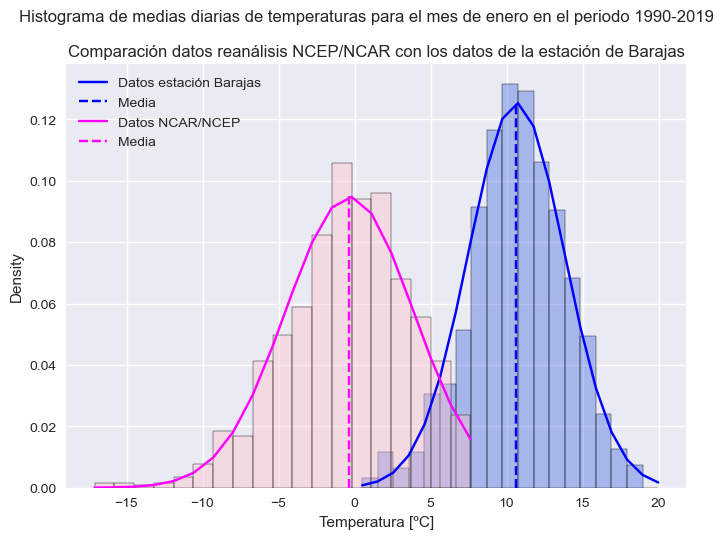

In [38]:

mean= np.mean(datos_estacion_enero['temp'])
std= np.std(datos_estacion_enero['temp'])
n= np.shape(datos_estacion_enero['temp'])[0]
bins= np.arange(np.min(datos_estacion_enero['temp']),np.max(datos_estacion_enero['temp']),step=(np.max(datos_estacion_enero['temp'])-np.min(datos_estacion_enero['temp']))/20)
fig,ax= plt.subplots()
sns.histplot(datos_estacion_enero, x='temp',bins=bins,stat='density',alpha=0.4,color='royalblue')
normal_distribution= stats.norm.pdf(bins,mean,std)
plt.plot(bins,normal_distribution,'blue',label='Datos estación Barajas')
alfa=0.05

x=np.zeros(10)
y=np.linspace(0,0.125,10)
plt.plot(x+mean,y,'--',color='blue',label='Media')

mean= np.mean(media_diaria_enero['temp'])
std= np.std(media_diaria_enero['temp'])
n= np.shape(media_diaria_enero['temp'])[0]
bins= np.arange(np.min(media_diaria_enero['temp']),np.max(media_diaria_enero['temp']),step=(np.max(media_diaria_enero['temp'])-np.min(media_diaria_enero['temp']))/20)
sns.histplot(media_diaria_enero, x='temp',bins=bins,stat='density',alpha=0.4,color='pink')
normal_distribution= stats.norm.pdf(bins,mean,std)
plt.plot(bins,normal_distribution,'magenta',label='Datos NCAR/NCEP')
y=np.linspace(0,0.095,10)
plt.plot(x+mean,y,'--',color='magenta',label='Media')

plt.legend(loc='best')
plt.xlabel('Temperatura [ºC]')
plt.title('Comparación datos reanálisis NCEP/NCAR con los datos de la estación de Barajas')
plt.suptitle('Histograma de medias diarias de temperaturas para el mes de enero en el periodo 1990-2019')
plt.show()


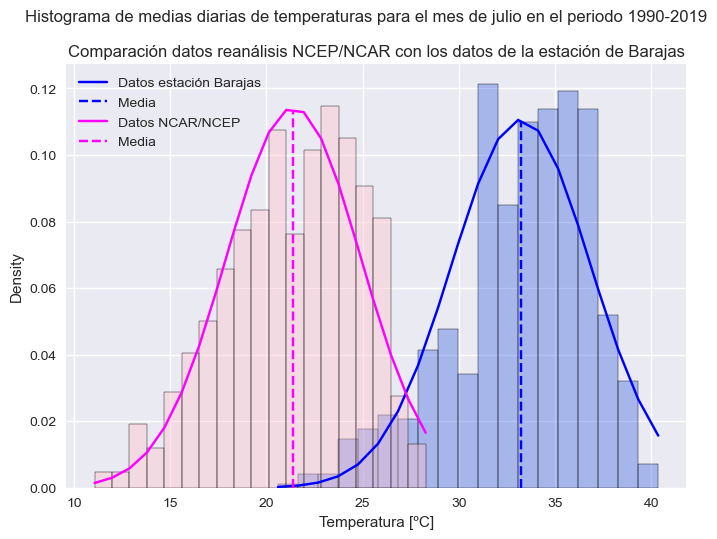

In [39]:
mean= np.mean(datos_estacion_julio['temp'])
std= np.std(datos_estacion_julio['temp'])
n= np.shape(datos_estacion_julio['temp'])[0]
bins= np.arange(np.min(datos_estacion_julio['temp']),np.max(datos_estacion_julio['temp']),step=(np.max(datos_estacion_julio['temp'])-np.min(datos_estacion_julio['temp']))/20)
fig,ax= plt.subplots()
sns.histplot(datos_estacion_julio, x='temp',bins=bins,stat='density',alpha=0.4,color='royalblue')
normal_distribution= stats.norm.pdf(bins,mean,std)
plt.plot(bins,normal_distribution,'blue',label='Datos estación Barajas')
alfa=0.05

x=np.zeros(10)
y=np.linspace(0,0.11,10)
plt.plot(x+mean,y,'--',color='blue',label='Media')

mean= np.mean(media_diaria_julio['temp'])
std= np.std(media_diaria_julio['temp'])
n= np.shape(media_diaria_julio['temp'])[0]
bins= np.arange(np.min(media_diaria_julio['temp']),np.max(media_diaria_julio['temp']),step=(np.max(media_diaria_julio['temp'])-np.min(media_diaria_julio['temp']))/20)
sns.histplot(media_diaria_julio, x='temp',bins=bins,stat='density',alpha=0.4,color='pink')
normal_distribution= stats.norm.pdf(bins,mean,std)
plt.plot(bins,normal_distribution,'magenta',label='Datos NCAR/NCEP')
y=np.linspace(0,0.113,10)
plt.plot(x+mean,y,'--',color='magenta',label='Media')

plt.legend(loc='best')
plt.xlabel('Temperatura [ºC]')
plt.title('Comparación datos reanálisis NCEP/NCAR con los datos de la estación de Barajas')
plt.suptitle('Histograma de medias diarias de temperaturas para el mes de julio en el periodo 1990-2019')
plt.show()
